In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
import sys as sys
import time
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import BasicTools as BT
import WaveTools as WT
import PlotTools as PT
import FFTTools as FFTT
import GridTransferTools as GTT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 1000)

This cell is where you set your inputs.

In [2]:
nh = 8
transferType = 'I'

This cell just checks to make sure your inputs are valid.

In [3]:
check = BT.CheckNumber(nh)

This cell runs the computations to find our step size, our cell-averaged and node-centered Fourier modes, and the eigenvalues of our the Laplacian.

In [4]:
omega = BT.Grid(nh)
waves = WT.MakeWaves(omega)
wavesNode = WT.MakeNodeWaves(omega)
cellEigs = WT.FindLaplaceEigVals(omega, waves)

if (transferType == 'I'):
    omega2 = BT.Grid(2 * nh)
    transfer = GTT.MakeInject(2 * nh)
else:
    if (transferType == 'FW'):
        omega2 = BT.Grid(2 * nh)
        transfer = GTT.MakeFullWeight(2 * nh)
    else:
        omega2 = BT.Grid(int(nh / 2))
        if (transferType == 'PW'):
            transfer = GTT.MakePiecewise(int(nh / 2))
        else:
            transfer = GTT.MakeLinearInterp(int(nh / 2))
waves2 = transfer @ WT.MakeWaves(omega2)

This cell overlays piecewise plots of our cell-averaged modes and scatter plots of our node-centered modes onto continuous plots of our Fourier modes.

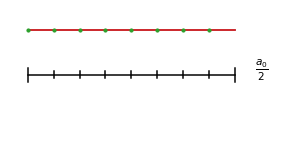

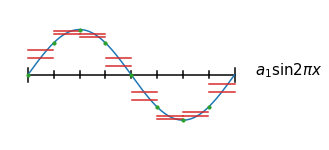

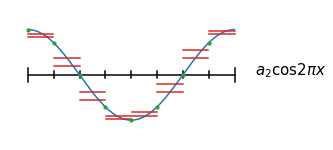

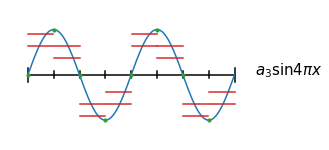

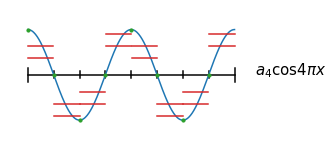

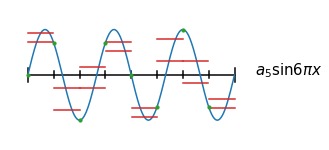

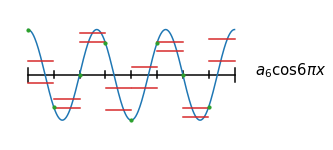

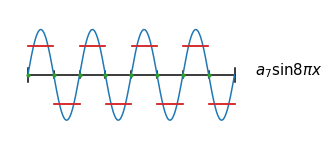

In [5]:
PT.PlotWaves(omega, waves, waveNode = wavesNode, waveTrans = waves2)

This cell creates an example vector of coefficients. It then runs an FFT on it and then runs an inverse FFT on that result back to the original vector of coefficients.

In [6]:
x_coefs = np.zeros(nh, float)
x_coefs[0] = 1.
x_coefs[1] = -2.
x_coefs[nh - 1] = 0.5

k_coefs = FFTT.GetKSpaceCoefs(omega, x_coefs, waves)
new_x_coefs = FFTT.GetXSpaceCoefs(omega, k_coefs, waves)

print('x_coefs =\n', x_coefs)
print('')
print('k_coefs =\n', k_coefs)
print('')
print('x_coefs =\n', new_x_coefs)
print('')

x_coefs =
 [ 1.  -2.   0.   0.   0.   0.   0.   0.5]

k_coefs =
 [ 0.5+0.j  0. +0.j  0. -0.j -0. -1.j  1. +0.j -0. +1.j  0. +0.j  0. -0.j]

x_coefs =
 [ 1.e+00 -2.e+00  1.e-14  0.e+00 -0.e+00  0.e+00  0.e+00  5.e-01]



/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/numpy/lib/index_tricks.py:861: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val


In [7]:
blah = np.arange(8).reshape(4, 2)
print(blah)
print(blah[:, 0])

[[0 1]
 [2 3]
 [4 5]
 [6 7]]
[0 2 4 6]


In [8]:
print(np.isreal(new_x_coefs).all())
print(np.real(new_x_coefs))

True
[ 1.e+00 -2.e+00  1.e-14  0.e+00 -0.e+00  0.e+00  0.e+00  5.e-01]


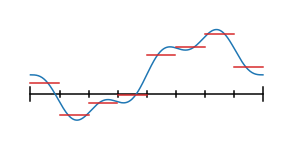

In [9]:
PT.PlotMixedWave(omega, waves, x_coefs)

In [10]:
print(np.diag(np.eye(nh)))

[1. 1. 1. 1. 1. 1. 1. 1.]
